# OIS Yield Curve Construction 

Constructing the OIS yield curve can be done via mid-quotes of market makers. The OIS curve can be constructed entirely from OIS instruments. For this yield curve construction we aim to find the OIS forward rate which can be found by discritizing the forward curve into daily rates, and fitting these to the zero-rates found by bootstrapping.

Thus, the construction is based on optimzation and not interpolation. 

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from amplpy import AMPL, Environment

path = "ampl/mac/ampl_macos64/"
ampl = AMPL(Environment(path))

%config InlineBackend.figure_format = 'retina'
sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

In order to bootstrap the OIS swap rates into continuously compounded zero rates we must import the data and compute the mid rates.

### Loading Swap Rates into DataFrames & Bootstrapping

In [78]:
df_mid = pd.read_excel("data/forwardRates.xlsx", sheet_name="MID")

In [83]:
dt = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
T = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [165]:
def bootstrap(swap_rates: np.array, dt: np.array, T: np.array) -> np.array:
    number_of_rates = len(swap_rates)
    zero_rates = np.zeros(number_of_rates)
    for i in range(number_of_rates):
        if T[i] <= 1:
            zero_rates[i] = 1/T[i] * np.log(1 + swap_rates[i] * dt[i])
        else:
            zero_rates[i] = 1/T[i] * np.log((1 + swap_rates[i] * dt[i]) / (1 - swap_rates[i] * np.sum(np.exp(-zero_rates[:i-1]*T[:i-1]) * dt[:i-1])))
    return zero_rates

In [202]:
swap_rates = np.array(df_mid.loc[22].values[1:])/100
zero_rates = bootstrap(swap_rates, dt, T)

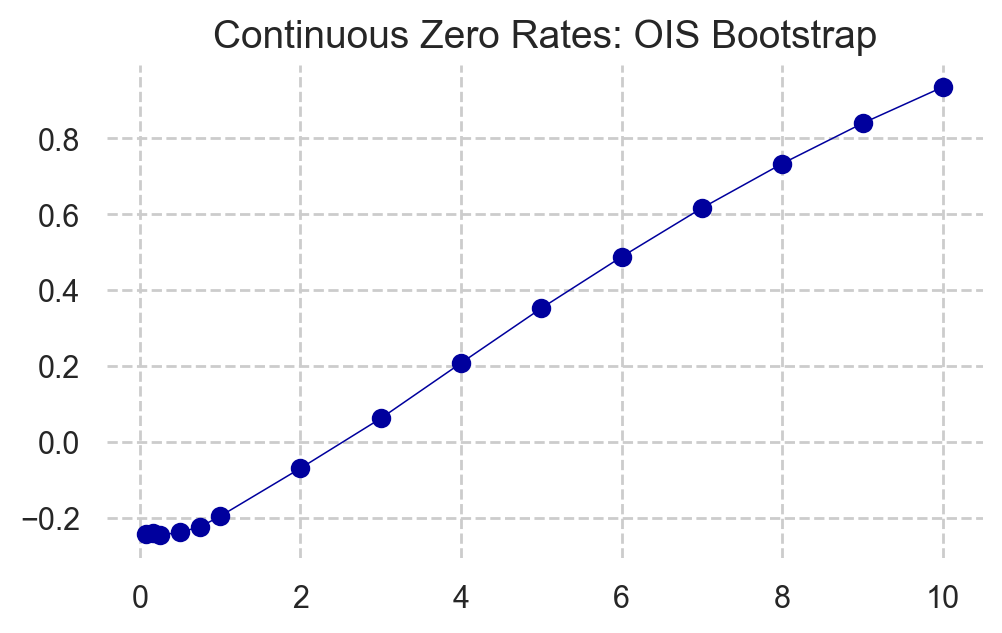

In [217]:
fig, ax = plt.subplots()
ax.plot(T, zero_rates*100, lw=0.55)
ax.scatter(T, zero_rates*100)
ax.set_title("Continuous Zero Rates: OIS Bootstrap", fontsize=14)
ax.set_frame_on(False)
fig.tight_layout()
fig.set_size_inches(5, 3)
plt.show()

### Constructing Yield Curve without Regularization

In [31]:
ampl.read('ampl/mac/ampl_macos64/models/diet.mod')
ampl.read_data('ampl/mac/ampl_macos64/models/diet.dat')

In [33]:
ampl.solve()

MINOS 5.51: optimal solution found.
6 iterations, objective 88.2


In [34]:
totalcost = ampl.get_objective('Total_Cost')
print("Objective is:", totalcost.get().value())

Objective is: 88.19999999999999


In [36]:
cost = ampl.get_parameter('cost')
cost.set_values({'BEEF': 5.01, 'HAM': 4.55})
print("Increased costs of beef and ham.")
ampl.solve();
print("New objective value:", totalcost.value())

Increased costs of beef and ham.
MINOS 5.51: optimal solution found.
0 iterations, objective 88.2
New objective value: 88.19999999999999


In [37]:
cost.set_values([3, 5, 5, 6, 1, 2, 5.01, 4.55])
print("Updated all costs.")
ampl.solve()
print("New objective value:", totalcost.value())

Updated all costs.
MINOS 5.51: optimal solution found.
1 iterations, objective 46.66666667
New objective value: 46.66666666666667


In [38]:
# Get the values of the variable Buy in a dataframe object
buy = ampl.get_variable('Buy')
df = buy.get_values()
# Print them
print(df)

   index0    |   Buy.val   
   'BEEF'    |      0      
   'CHK'     |      0      
   'FISH'    |      0      
   'HAM'     |      0      
   'MCH'     | 46.666666666666671
   'MTL'     | 1.5761812194954111e-15
   'SPG'     |      0      
   'TUR'     |      0      



In [39]:
# Get the values of an expression into a DataFrame object
df2 = ampl.get_data("{j in FOOD} 100*Buy[j]/Buy[j].ub")
# Print them
print(df2)

   index0    | 100*Buy[j]/(Buy[j].ub)
   'BEEF'    |      0      
   'CHK'     |      0      
   'FISH'    |      0      
   'HAM'     |      0      
   'MCH'     | 46.666666666666671
   'MTL'     | 1.5761812194954111e-15
   'SPG'     |      0      
   'TUR'     |      0      



### Constructing Yield Curve with Regularization

### PCA: Yield Curve Driving Factors